<a href="https://colab.research.google.com/github/LubangaD/Stockanalysis/blob/main/169240_L_Derrick_DSA8203_CAT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NAME**: *DERRICK* *LUBANGA*<br>
**REG NUMBER** *169240*<br>
**TASK** *CAT 2*<br>


***STOCK ANALYSIS FOR KPLC STOCKS FROM 2013 - 2020.***<br><br>
**PART 1**: *STOCK ANALYSIS*<br>
**PART 2**: *SENTIMENT ANALYSIS OF KPLC REPORT*



In [116]:
#Include libraries to be used
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

import warnings
warnings.filterwarnings("ignore")

In [115]:
from io import StringIO
import requests

# URLs of the CSV files
urls = [
    "https://github.com/LubangaD/Stockanalysis/raw/main/NSE_data_all_stocks_2013.csv",
    "https://github.com/LubangaD/Stockanalysis/raw/main/NSE_data_all_stocks_2014.csv",
    "https://github.com/LubangaD/Stockanalysis/raw/main/NSE_data_all_stocks_2015.csv",
    "https://github.com/LubangaD/Stockanalysis/raw/main/NSE_data_all_stocks_2016.csv",
    "https://github.com/LubangaD/Stockanalysis/raw/main/NSE_data_all_stocks_2017.csv",
    "https://github.com/LubangaD/Stockanalysis/raw/main/NSE_data_all_stocks_2018.csv",
    "https://github.com/LubangaD/Stockanalysis/raw/main/NSE_data_all_stocks_2019.csv",
    "https://github.com/LubangaD/Stockanalysis/raw/main/NSE_data_all_stocks_2020.csv"
]

# Dictionary to store dataframes
dataframes = {}

# Fetch and process each CSV file
for url in urls:
    # Fetch the content from the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the content into a file-like object
        content = StringIO(response.text)

        # Extract the year from the URL
        year = url.split("_")[-1].split(".")[0]

        # Read the CSV file into a DataFrame
        df = pd.read_csv(content)

        # Store the DataFrame in the dictionary
        dataframes[year] = df
    else:
        print(f"Failed to fetch data from the URL: {url}")

# Access the dataframes using the year as keys
for year, df in dataframes.items():
    print(f"Data for year {year}:")



Data for year 2013:
Data for year 2014:
Data for year 2015:
Data for year 2016:
Data for year 2017:
Data for year 2018:
Data for year 2019:
Data for year 2020:


In [117]:
#This code will load all the datasets from the provided URLs, combine them into a single DataFrame,
#perform the specified data cleaning tasks, and select the rows where the 'NAME' column matches 'KPLC-P4',
#'KPLC-P7', or 'Kenya Power and Lighting Company Plc'

# List to hold individual dataframes
dfs = []

# Fetch and process each CSV file
for url in urls:
    # Read CSV file into DataFrame
    df = pd.read_csv(url)
    # Append DataFrame to list
    dfs.append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# Select only numeric columns
numeric_columns = combined_df.select_dtypes(include=['number']).columns

# Convert non-numeric columns to numeric
def convert_columns_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' to handle non-convertible values

# List of columns to convert to numeric
columns_to_convert = ['12m Low', '12m High', 'Day Low', 'Day High', 'Day Price', 'Previous', 'Change', 'Change%', 'Volume', 'Adjust']
convert_columns_to_numeric(combined_df, columns_to_convert)

# Drop the 'Adjust' column
combined_df = combined_df.drop('Adjust', axis=1)

# Select rows where the 'NAME' column matches 'KPLC-P4' or 'KPLC-P7'
KPLC = combined_df[combined_df['NAME'].isin(['KPLC-P4', 'KPLC-P7', 'Kenya Power and Lighting Company Plc'])].copy()

# Display the first few rows of the new DataFrame
KPLC.head()


,DATE,CODE,NAME,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,Change%,Volume
34,2-Jan-13,KPLC-P4,KPLC-P4,5.00,5.00,7.65,7.65,7.65,7.65,NaN,NaN,NaN
35,2-Jan-13,KPLC-P7,KPLC-P7,6.00,6.00,5.50,5.50,5.50,5.50,NaN,NaN,NaN
36,2-Jan-13,KPLC,Kenya Power and Lighting Company Plc,1.63,4.15,17.00,17.45,17.00,17.10,-0.1,NaN,NaN
93,3-Jan-13,KPLC-P4,KPLC-P4,5.00,5.00,7.65,7.65,7.65,7.65,NaN,NaN,NaN
94,3-Jan-13,KPLC-P7,KPLC-P7,6.00,6.00,5.50,5.50,5.50,5.50,NaN,NaN,NaN


In [118]:
KPLC.columns

Index(['DATE', 'CODE', 'NAME', '12m Low', '12m High', 'Day Low', 'Day High',
       'Day Price', 'Previous', 'Change', 'Change%', 'Volume'],
      dtype='object')

In [119]:
KPLC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5979 entries, 34 to 134410
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       5979 non-null   object 
 1   CODE       5979 non-null   object 
 2   NAME       5979 non-null   object 
 3   12m Low    5979 non-null   float64
 4   12m High   5979 non-null   float64
 5   Day Low    5979 non-null   float64
 6   Day High   5979 non-null   float64
 7   Day Price  5979 non-null   float64
 8   Previous   5979 non-null   float64
 9   Change     1600 non-null   float64
 10  Change%    0 non-null      float64
 11  Volume     140 non-null    float64
dtypes: float64(9), object(3)
memory usage: 607.2+ KB


In [120]:
KPLC.isna().sum()

DATE            0
CODE            0
NAME            0
12m Low         0
12m High        0
Day Low         0
Day High        0
Day Price       0
Previous        0
Change       4379
Change%      5979
Volume       5839
dtype: int64

In [121]:
#Drop columns which have lots of Null values that we will not use for analysis
KPLC.drop(['Change%', 'Change', 'Volume'], axis=1, inplace=True)
KPLC.head()

,DATE,CODE,NAME,12m Low,12m High,Day Low,Day High,Day Price,Previous
34,2-Jan-13,KPLC-P4,KPLC-P4,5.00,5.00,7.65,7.65,7.65,7.65
35,2-Jan-13,KPLC-P7,KPLC-P7,6.00,6.00,5.50,5.50,5.50,5.50
36,2-Jan-13,KPLC,Kenya Power and Lighting Company Plc,1.63,4.15,17.00,17.45,17.00,17.10
93,3-Jan-13,KPLC-P4,KPLC-P4,5.00,5.00,7.65,7.65,7.65,7.65
94,3-Jan-13,KPLC-P7,KPLC-P7,6.00,6.00,5.50,5.50,5.50,5.50


In [122]:
#Set the Year Column as the Index
KPLC = KPLC.set_index('DATE')

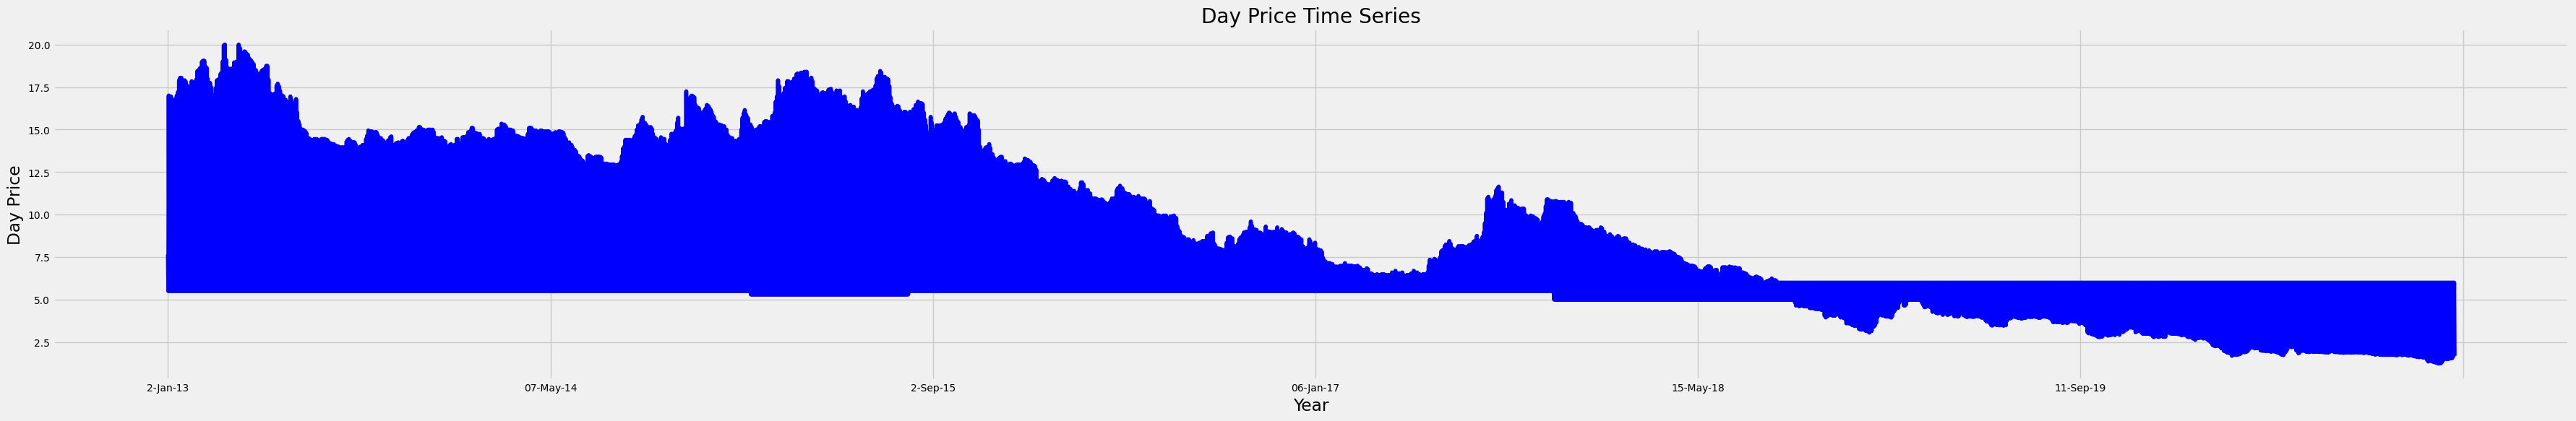

In [123]:
#Plot a time series for the day prices
import matplotlib.pyplot as plt
# Log transformation of the prices
log_prices = np.log(KPLC['Day Price'])
plt.style.use('fivethirtyeight')

df_subset = KPLC['Day Price']

# Plot the time series
plt.figure(figsize=(40, 6))
ax = df_subset.plot(color='blue', fontsize=10)

# Set plot title and axis labels
ax.set_title('Day Price Time Series')
ax.set_xlabel('Year')
ax.set_ylabel('Day Price')

plt.show()


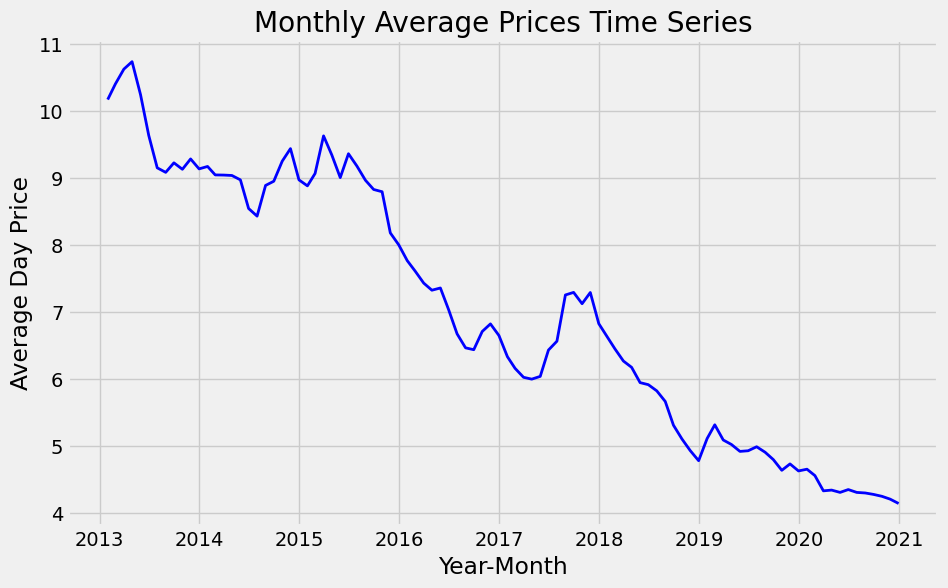

In [124]:
# Convert the index to datetime format
KPLC.index = pd.to_datetime(KPLC.index)
# Resample the daily prices to monthly frequency and calculate the mean for each month
monthly_prices = KPLC['Day Price'].resample('M').mean()

# Drop NaN values if any
monthly_prices = monthly_prices.dropna()

# Increase the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the time series of monthly average prices
plt.plot(monthly_prices, color='blue', linewidth=2)

# Set plot title and axis labels
plt.title('Monthly Average Prices Time Series')
plt.xlabel('Year-Month')
plt.ylabel('Average Day Price')

plt.grid(True)

plt.show()


In [125]:
monthly_prices=pd.DataFrame(monthly_prices)

In [126]:
#Check for stationarity
from statsmodels.tsa.stattools import adfuller

adf_stats = adfuller(monthly_prices['Day Price'])
x = 'the data is non stationary' if adf_stats[1] >= 0.05 else 'the data is stationary'
print(f'The p-value is: {round(adf_stats[1],2)} hence {x}')

The p-value is: 0.71 hence the data is non stationary


In [127]:
#We need to make the data stationary
monthly_prices['Day Price_diff'] = monthly_prices['Day Price'].shift(1)
monthly_prices['Day Price_change'] = monthly_prices['Day Price'] - monthly_prices['Day Price_diff']
monthly_prices['Day Price'].dropna(inplace=True)
monthly_prices['Day Price'].head()

DATE
2013-01-31    10.168939
2013-02-28    10.401667
2013-03-31    10.622807
2013-04-30    10.734167
2013-05-31    10.241667
Freq: M, Name: Day Price, dtype: float64

In [128]:
missing_values = monthly_prices['Day Price_change'].isnull().sum()
print(f"Number of missing values in 'Day Price_change' column: {missing_values}")


Number of missing values in 'Day Price_change' column: 1


In [129]:
# Impute missing values with the mean
monthly_prices['Day Price_change'].fillna(monthly_prices['Day Price_change'].mean(), inplace=True)


In [130]:
#Check for stationarity
from statsmodels.tsa.stattools import adfuller

adf_stats = adfuller(monthly_prices['Day Price_change'])
x = 'the data is non stationary' if adf_stats[1] >= 0.05 else 'the data is stationary'
print(f'The p-value is: {round(adf_stats[1],2)} hence {x}')

The p-value is: 0.0 hence the data is stationary


In [131]:
monthly_prices.head()

,Day Price,Day Price_diff,Day Price_change
DATE,,,
2013-01-31,10.168939,NaN,-0.063418
2013-02-28,10.401667,10.168939,0.232727
2013-03-31,10.622807,10.401667,0.221140
2013-04-30,10.734167,10.622807,0.111360
2013-05-31,10.241667,10.734167,-0.492500


**Since our data is now  stationary let us do prediction of day prices**

**We first get the acf and pacf of our daily price to get the order of the model**

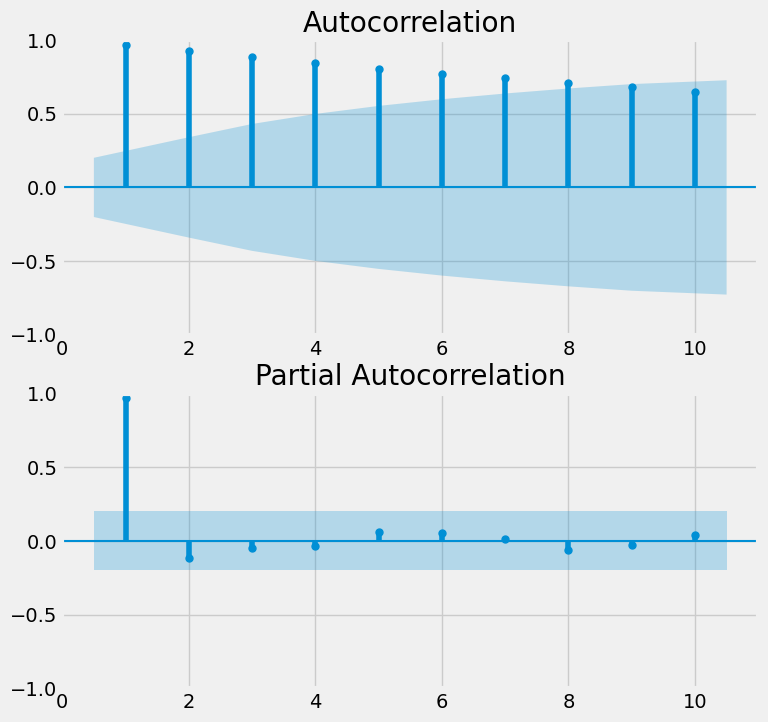

In [132]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
# Make ACF plot
plot_acf(monthly_prices['Day Price_diff'].dropna(), lags=10, zero=False, ax=ax1,  linewidth=1.5)
# Make PACF plot
plot_pacf(monthly_prices['Day Price_diff'].dropna(), lags=10, zero=False, ax=ax2,  linewidth=1.5)
plt.show()


**From the above plots this is an AR(p) model as the ACF Tails of while the PACF cuts off after a lag p**

In [133]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(monthly_prices['Day Price_change'], order=(0,0,1))
results = model.fit()

In [134]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:       Day Price_change   No. Observations:                   96
Model:                 ARIMA(0, 0, 1)   Log Likelihood                   9.203
Date:                Tue, 06 Feb 2024   AIC                            -12.406
Time:                        15:26:44   BIC                             -4.713
Sample:                    01-31-2013   HQIC                            -9.297
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0636      0.030     -2.138      0.033      -0.122      -0.005
ma.L1          0.2799      0.114      2.463      0.014       0.057       0.503
sigma2         0.0483      0.006      8.671      0.0

In [135]:
#Make predictions for last 25 values
results = model.fit()
#Make in-sample prediction
forecast = results.get_prediction(start=-25)
# forecast mean
mean_forecast = forecast.predicted_mean

In [136]:
# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()
confidence_intervals

,lower Day Price_change,upper Day Price_change
DATE,,
2018-12-31,-0.519559,0.341855
2019-01-31,-0.511998,0.349417
2019-02-28,-0.379109,0.482306
2019-03-31,-0.451414,0.410000
2019-04-30,-0.552042,0.309373
2019-05-31,-0.479116,0.382299
2019-06-30,-0.509604,0.351811
2019-07-31,-0.469553,0.391862
2019-08-31,-0.466798,0.394616


**PLOTS FOR THE FORECATS OF OUR DAY PRICE**

<Figure size 1000x600 with 0 Axes>

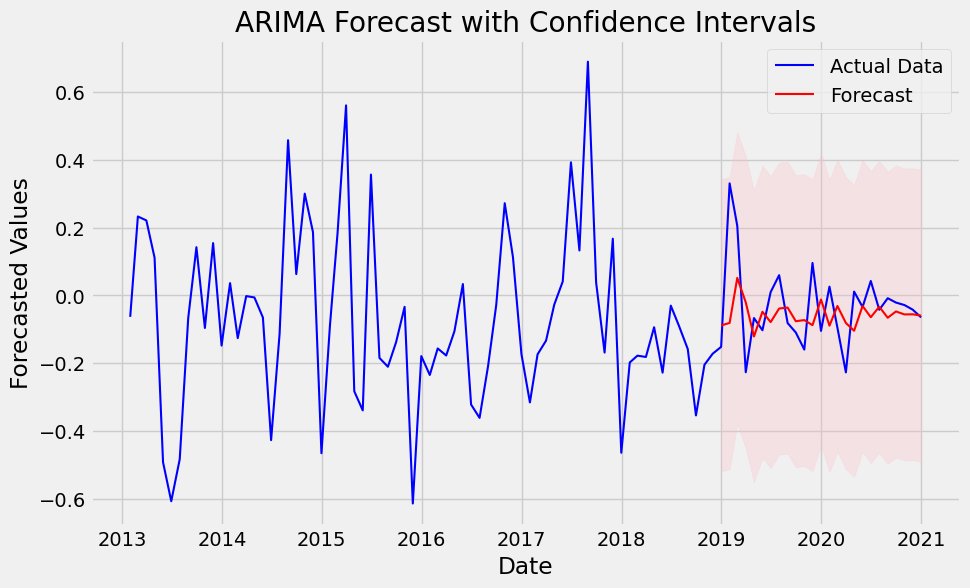

In [137]:
# Plot the forecasts
plt.figure(figsize=(10, 6))
# Plot actual data
plt.figure(figsize=(10, 6))
plt.plot(monthly_prices.index, monthly_prices['Day Price_change'], label='Actual Data', color='blue',  linewidth=1.5)

# Plot the mean forecast
plt.plot(monthly_prices.index[-25:], mean_forecast.values, color='red', label='Forecast',  linewidth=1.5)

#Shade the uncertainty area
plt.fill_between(monthly_prices.index[-25:], confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Forecasted Values')
plt.title('ARIMA Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**SENTIMENT ANALYSIS FOR KPLC LATEST REPORT**

In [138]:
# Read the Excel file specifying the engine as xlrd
df = pd.read_excel('https://raw.githubusercontent.com/LubangaD/Stockanalysis/main/KPLC_reports.xlsx')

# Display the DataFrame
df.head()


,Year,Text
0,2019,The Kenya Power and Lighting Company Plc Annua...
1,2021,THE KENYA POWER AND LIGHTING COMPANY PLC\nANNU...
2,2023,ANNUAL REPORT AND FINANCIAL STATEMENTS FOR THE...


In [139]:
df.dropna(inplace=True)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    3 non-null      int64 
 1   Text    3 non-null      object
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


**Text processing**<br>
 Preparing text data for analysis by performing

Lowercasing: Convert all text to lowercase to ensure consistency in the text.

Tokenization: Split the text into individual words or tokens.

Removing Punctuation: Remove any punctuation marks from the text.

Removing Stopwords: Remove common words that do not carry much meaning, such as 'the', 'is', 'are', etc.

Stemming or Lemmatization: Reduce words to their base or root form to normalize the text.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


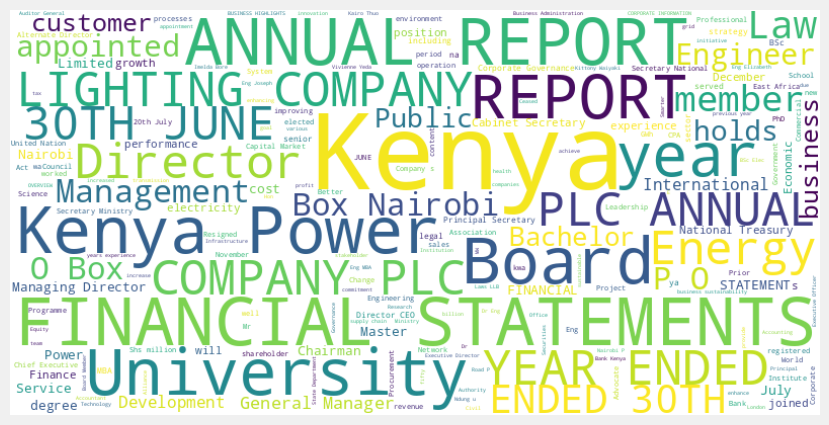

      Sentiment
Year           
2019     0.9997
2021     0.9998
2023     0.9999


In [141]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('vader_lexicon')

# Tokenize words and perform sentiment analysis for each year
sid = SentimentIntensityAnalyzer()
sentiments = []

# Assuming df is your DataFrame with 'Year' and 'Text' columns
for year, group in df.groupby('Year'):
    all_text = ' '.join(group['Text'])
    tokens = word_tokenize(all_text)
    sentiment_score = sid.polarity_scores(all_text)['compound']
    sentiments.append((year, sentiment_score))

# Convert sentiments to DataFrame
sentiments_df = pd.DataFrame(sentiments, columns=['Year', 'Sentiment']).set_index('Year')

# Word cloud visualization for all years combined
all_text = ' '.join(df['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Summary of sentiments
print(sentiments_df)

In [165]:
from nltk.corpus import stopwords

# Assuming 'Sentence' is the column containing text data in your DataFrame
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a sentence
def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the 'Sentence' column
sentiment_df['Sentence_without_stopwords'] = sentiment_df['Sentence'].apply(remove_stopwords)


In [166]:
sentiment_df.head()

,Sentence,Sentiment,Year,temp_list,temp_list1,Sentence_without_stopwords
0,The Kenya Power and Lighting Company Plc Annua...,Positive,2019,"[The, Kenya, Power, Lighting, Company, Plc, An...","[The, Kenya, Power, Lighting, Company, Plc, An...",Kenya Power Lighting Company Plc Annual Report...
1,By becoming the preferred energy solution for ...,Positive,2019,"[By, becoming, preferred, energy, solution, bu...","[By, becoming, preferred, energy, solution, bu...",becoming preferred energy solution businesses ...
2,By striving to provide world-class products an...,Positive,2019,"[By, striving, provide, world-class, products,...","[By, striving, provide, world-class, products,...",striving provide world-class products services...
3,CORE VALUES\nWe put our customers first as the...,Positive,2019,"[CORE, VALUES, We, put, customers, first, matt...","[CORE, VALUES, We, put, customers, first, matt...",CORE VALUES put customers first matter work to...
4,The report will be considered by shareholders ...,Neutral,2019,"[The, report, considered, shareholders, adopti...","[The, report, considered, shareholders, adopti...",report considered shareholders adoption 98th A...


In [172]:
# Define a function to perform sentiment analysis using NLTK's Vader
def analyze_sentiment_vader(sentence):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(sentence)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Create a new DataFrame to store sentence-level results
sentiment_df = pd.DataFrame(columns=['Sentence', 'Sentiment', 'Year'])

# Iterate through each row, tokenize the text into sentences, and perform sentiment analysis
for index, row in df.iterrows():
    text = row['Text']
    year = row['Year']

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Perform sentiment analysis for each sentence
    for sentence in sentences:
        # Remove stopwords
        sentence_without_stopwords = remove_stopwords(sentence)

        # Perform sentiment analysis using NLTK's Vader
        sentiment_vader = analyze_sentiment_vader(sentence_without_stopwords)

        # Append the results to the new DataFrame
        sentiment_df = sentiment_df.append({'Sentence': sentence_without_stopwords, 'Sentiment': sentiment_vader, 'Year': year}, ignore_index=True)

# Display the resulting DataFrame
sentiment_df.head()


,Sentence,Sentiment,Year
0,Kenya Power Lighting Company Plc Annual Report...,Positive,2019
1,becoming preferred energy solution businesses ...,Positive,2019
2,striving provide world-class products services...,Positive,2019
3,CORE VALUES put customers first matter work to...,Positive,2019
4,report considered shareholders adoption 98th A...,Neutral,2019


In [173]:
#Distribution of Sentiments
temp = sentiment_df.groupby('Sentiment').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
temp.style.background_gradient(cmap='Purples')


,Sentiment,Sentence
1,Neutral,374
2,Positive,232
0,Negative,28


In [174]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   634 non-null    object
 1   Sentiment  634 non-null    object
 2   Year       634 non-null    object
dtypes: object(3)
memory usage: 15.0+ KB


<Figure size 1200x800 with 0 Axes>

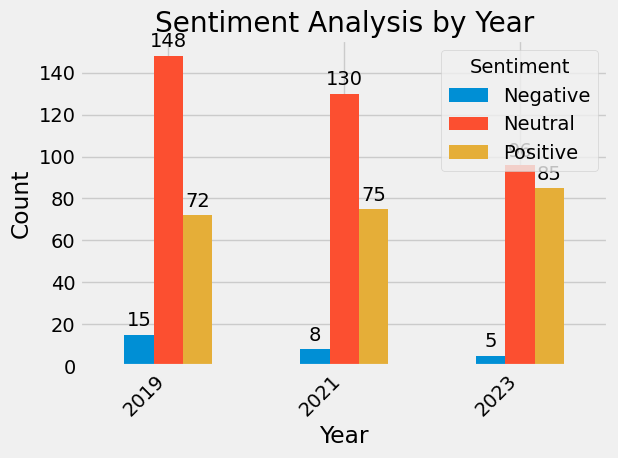

In [175]:
# Group by year and sentiment
grouped_df = sentiment_df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiments for each year with a larger figure size
plt.figure(figsize=(12, 8))# Plot the sentiments for each year
ax = grouped_df.plot(kind='bar')
plt.title('Sentiment Analysis by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')

# Annotate bars with data values
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

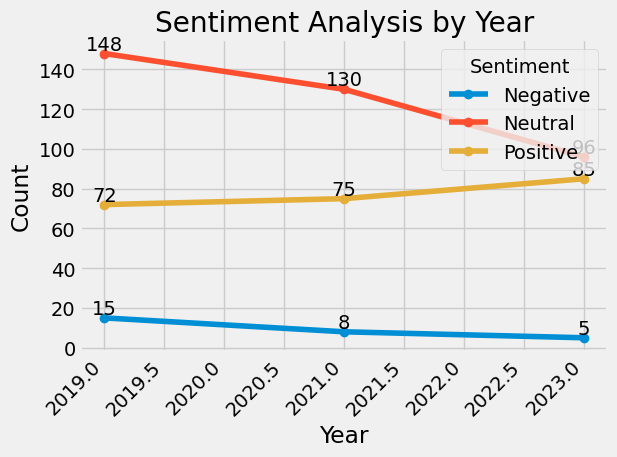

In [176]:
# Group by year and sentiment
grouped_df = sentiment_df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiments for each year with a larger figure size
plt.figure(figsize=(12, 8))

# Plot the sentiments for each year using a line plot
grouped_df.plot(kind='line', marker='o', linestyle='-')

plt.title('Sentiment Analysis by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')

# Annotate data points with values
for year in grouped_df.index:
    for sentiment, count in grouped_df.loc[year].items():
        plt.text(year, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [177]:
# Calculate the total count for each year
total_counts = grouped_df.sum(axis=1)

# Calculate the percentage of each sentiment count relative to the total count for each year
percentage_df = grouped_df.div(total_counts, axis=0)

# Display the resulting DataFrame
percentage_df

Sentiment,Negative,Neutral,Positive
Year,,,
2019,0.063830,0.629787,0.306383
2021,0.037559,0.610329,0.352113
2023,0.026882,0.516129,0.456989


In [148]:
grouped_df.columns

Index(['Negative', 'Neutral', 'Positive'], dtype='object', name='Sentiment')

In [149]:
temp.columns

Index(['Sentiment', 'Sentence'], dtype='object')

In [178]:
fig = go.Figure(go.Funnelarea(
    text =temp.Sentiment,
    values = temp.Sentence,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

<Axes: xlabel='Sentiment', ylabel='count'>

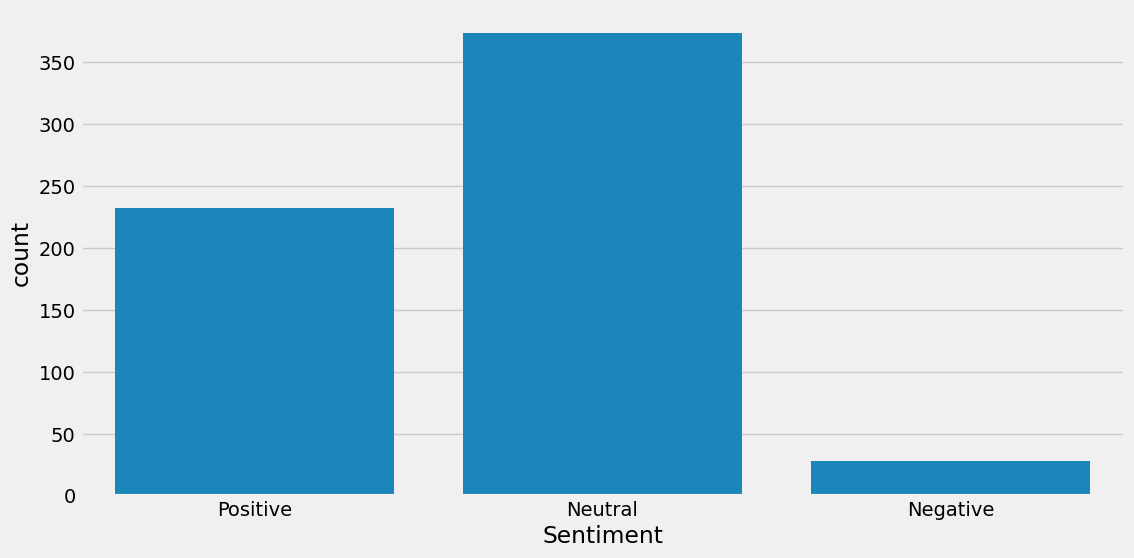

In [179]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=sentiment_df)

**Most common words**

In [180]:
from collections import Counter
sentiment_df['temp_list'] = sentiment_df['Sentence'].apply(lambda x:str(x).split())
top = Counter([item for sublist in sentiment_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,Kenya,114
1,Eng.,70
2,Director,67
3,Board,66
4,&,61
5,REPORT,59
6,Company,58
7,Nairobi,57
8,University,55
9,FINANCIAL,53


In [181]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

**Most Common words in Text**

In [183]:
sentiment_df['temp_list1'] = sentiment_df['Sentence'].apply(lambda x:str(x).split()) #List of words in every row for text
sentiment_df['temp_list1'] = sentiment_df['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [184]:
top = Counter([item for sublist in sentiment_df['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,Eng.,70
2,Director,67
3,Board,66
4,&,61
5,REPORT,59
6,Company,58
7,Nairobi,57
8,University,55
9,FINANCIAL,53
10,JUNE,53


In [185]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

**Most common words Sentiments Wise**

In [186]:
Positive_sent = sentiment_df[sentiment_df['Sentiment']=='Positive']
Negative_sent = sentiment_df[sentiment_df['Sentiment']=='Negative']
Neutral_sent = sentiment_df[sentiment_df['Sentiment']=='Neutral']

In [187]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,Kenya,43
1,REPORT,39
2,Energy,38
3,Director,38
4,FINANCIAL,33
5,JUNE,33
6,YEAR,32
7,ENDED,31
8,"Secretary,",30
9,Company,29


In [188]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [189]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,2020,12
2,-,11
3,Imelda,10
4,Bank,9
5,Kenya,9
6,13,9
7,Secretary,8
8,20,7
9,Bore,7
10,Limited,7


In [190]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,Eng.,59
2,University,46
3,Nairobi,41
4,Board,33
5,P.O.,30
6,Box,29
7,holds,29
8,General,28
9,"),",28
10,&,27


In [191]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

**Sentiment Distribution:** The majority of sentiments observed are Neutral, followed by Positive, with Negative sentiments being the least common. This indicates a relatively balanced sentiment distribution overall.

**Top Neutral Word:** The most frequently occurring word in Neutral sentiments is 'Eng', suggesting the significance of engineers within the company. This insight sheds light on the workforce composition or operational aspects of the company.

**Location and Industry:** The presence of the word 'Kenya' as the most common word implies that the company is based in Kenya. Additionally, the prevalence of 'Energy' indicates that the company operates within the energy sector, providing insight into its industry focus.

**Sentiment Trends:** The line plot illustrates a trend where Neutral and Negative sentiments are decreasing over time, while Positive sentiments are increasing. This trend signifies positive developments or improvements within the company, indicating favorable sentiment trends among stakeholders.